# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

[Diary Data Dictionary](https://www.bls.gov/cex/2015/csxdiarydata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2015 diary zip file](https://www.bls.gov/cex/pumd/data/comma/diary15.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD 
- Create a csv files that has average percentages spent on plynty categories for certain income classes
- Compare the Family CUs vs the Single person CUs

##### Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import math
import matplotlib.pyplot as plt
from scipy.interpolate import *
from plyntywidgets import *
from blsFunctions import *

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='adyke', api_key='wSGAvFQyxDbbXm8etral')

print("Dependencies Loaded...")

Dependencies Loaded...


### Setting Parameters
- year: the last two number associated with the year of the data
    for example for data from 2015: year = "15"
- minAge: the low bound (inclusive) of the age range you wish to subset by
- maxAge: the high bound (inclusive) of the age range you wish to subset by
- incomeBrackets: array of numbers that you wish to create the new income classes
    the bracketing works as follows (1,2], (2,3], (3,4]
- filesToRead: the strings of the abbreviations associated with the files you wish to read
    options are: "all", "diary", "interview", "dtbd", "expd", "fmld", "memd", "fmli", "itbi", "memi", "mtbi", "ntaxi"

In [2]:
year = "15"
filesToRead = ["fmli", "mtbi"]
incomeBrackets = [-10000000, 10000, 20000, 40000, 60000, 80000, 90000, 130000, 160000, 240000, 9990000]
minAge = 60
maxAge = 75

### Setting Directory locations and FileNames on your Local Machine

In [3]:
# directory in which the diary and interview folders are held is located
diaryDir = "/Users/adyke/Vizuri/CE_PUMD/diary15/"
interviewDir = "/Users/adyke/Vizuri/CE_PUMD/intrvw15/"

# Directory where stubfiles are located
pathToStubFileDir = "/Users/adyke/Vizuri/Stubfiles/"
rScriptStubfilePathAndName = "/Users/adyke/Vizuri/BLS_Python_Analysis/creatingStubCsvs.R"

# Filenames of the Stubfiles
IStubFileName = "IStub2015.txt"
DStubFileName = "DStub2015.txt"
IntStubFileName = "IntStub2015.txt"

# name of interview dir within the interview dir
insideIntrvwDirName = "intrvw"

# name of the directory where you want the output percentages csv
outputDir = "/Users/adyke/Vizuri/outputFiles/"

### Reading in the files specified by FilesToRead

In [4]:
if(len(filesToRead)==0):
    print("The files to read variable is empty.")

# looping through each file to read
for file in filesToRead:
    if file == "dtbd" or file == "all" or file == "diary":
        dtbd = readFileSet("dtbd", diaryDir)
    if file == "expd" or file == "all" or file == "diary":
        expd = readFileSet("expd", diaryDir)
    if file == "fmld" or file == "all" or file == "diary":
        fmld = readFileSet("fmld", diaryDir)
    if file == "memd" or file == "all" or file == "diary":
        memd = readFileSet("memd", diaryDir)
    if file == "fmli" or file == "all" or file == "interview":
        fmli = readFileSet("fmli", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itbi" or file == "all" or file == "interview":
        itbi = readFileSet("itbi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itii" or file == "all" or file == "interview":
        itii = readFileSet("itii", interviewDir+insideIntrvwDirName+year+"/")
    if file == "memi" or file == "all" or file == "interview":
        memi = readFileSet("memi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "mtbi" or file == "all" or file == "interview":
        mtbi = readFileSet("mtbi", interviewDir+insideIntrvwDirName+year+"/")
        mtbi.UCC = mtbi.UCC.astype(str)
    if file == "ntaxi" or file == "all" or file == "interview":
        ntaxi = readFileSet("ntaxi", interviewDir+insideIntrvwDirName+year+"/")
# does not read form the expn or para subdirectories


### Using R to convert the Stub files into csv files

In [5]:
if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+IStubFileName+" "+DStubFileName+" "+IntStubFileName, shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)

Stubfiles Exist


### Reading and Cleaning the stubfile CSVs into pandas dataframes

In [6]:
# reading in the stubfiles
DStub = pd.read_csv(pathToStubFileDir+"DStub.csv")
IStub = pd.read_csv(pathToStubFileDir+"IStub.csv")
IntStub = pd.read_csv(pathToStubFileDir+"IntStub.csv")

# removing the index from the stufile
DStub = DStub.drop(DStub.columns[0], axis=1)
IStub = IStub.drop(IStub.columns[0], axis=1)
IntStub = IntStub.drop(IntStub.columns[0], axis=1)

# replacing * with 0 in the level columns
DStub.loc[DStub.level == "*", 'level'] = 0
IStub.loc[IStub.level == "*", 'level'] = 0
IntStub.loc[IntStub.level == "*", 'level'] = 0

# Starting the Plynty calculations

### Adding and Rolling up the MTBI Categories into mtbiRolledUp

outputs from cell:
- mtbiTrimmed: Dataframe with NewID, TotatlExp and each entry of cost.

In [7]:
rollupDict = {"iTotalExp":(categoricalUCCRollUp(IStub,["TOTALE"])),
"iFoodAtHome":(categoricalUCCRollUp(IStub, ["FOODHO", "ALCHOM"])),
"iFoodAway":(categoricalUCCRollUp(IStub, ["FOODAW", "ALCAWA"])),
"iHousing":(categoricalUCCRollUp(IStub, ["HOUSIN"], ignoreUCCs = categoricalUCCRollUp(IStub, ["UTILS"]))),
"iUtilites":(categoricalUCCRollUp(IStub, ["UTILS"])),
"iClothingAndBeauty":(categoricalUCCRollUp(IStub, ["APPARE","PERSCA"])),
"iTransportation":(categoricalUCCRollUp(IStub, ["TRANS"])),
"iHealthcare":(categoricalUCCRollUp(IStub, ["HEALTH"])),
"iEntertainment":(categoricalUCCRollUp(IStub, ["ENTRTA","READIN"])),
"iMiscellaneous":(categoricalUCCRollUp(IStub, ["MISC","TOBACC"])),
"iCharitableAndFamilyGiving":(categoricalUCCRollUp(IStub, ["CASHCO"])),
"iInsurance":(categoricalUCCRollUp(IStub, ["LIFEIN"])),
"iEducation":(categoricalUCCRollUp(IStub, ["EDUCAT"])),
"iHousingPrinciple":(categoricalUCCRollUp(IStub,["MRTPRI"]))}

# there is a multiple of 4 because each survey lasts for 3 months 
# multiplying by 4 gives a estimate for each year (3 * 4 = 12)
mtbiRolledUp = rollUpDataframeDict(mtbi, rollupDict, negativeColumns=["iHousingPrinciple"], multiple=4)
        
mtbiTrimmed = mtbiRolledUp.loc[: , ['NEWID','iTotalExp','iFoodAtHome','iFoodAway','iHousing','iUtilites','iClothingAndBeauty','iTransportation','iHealthcare','iEntertainment','iMiscellaneous','iCharitableAndFamilyGiving','iInsurance','iEducation','iHousingPrinciple']]

### Creating average expended on healthcare

### Creating the Sum for all expenditure category columns for each NEWID
nonZeroColumns is an array that contains the names of columns that should not be Zero

outputs from cell:
- iExpensesByNewID: total expenses for each category for each NewID

In [8]:
# adding up all columns for each new id
iExpensesByNewID = mtbiTrimmed.groupby(['NEWID'],as_index=False).sum()
# removing rows with zero values in key categories
nonZeroColumns = ['iFoodAtHome','iFoodAway','iHousing','iUtilites']
for column in nonZeroColumns:
    iExpensesByNewID = iExpensesByNewID[iExpensesByNewID[column] != 0]
iExpensesByNewID['iHousing'] = iExpensesByNewID['iHousing']+iExpensesByNewID['iHousingPrinciple']

### Subestting FMLI for age and recoding the incomebrackets

In [9]:
# subsetting for the age bracket
fmliAge = subsetDataframe(dataframe=fmli, columnName="AGE_REF", minValue=minAge, maxValue=maxAge)
fmliAge = fmliAge.reset_index()

# recoding the income brackets
fmliRecoded = binColumn(dataframe=fmliAge, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(1,len(incomeBrackets)))

allNEWIDs = list(fmliRecoded["NEWID"])

### Subsetting for Single person CU and Family CU
- should the subsetting be for family size or should it be for single parents?

In [10]:
# Family
fmliRecodedFamily = fmliRecoded.loc[fmliRecoded.FAM_SIZE > 1]
# Single
fmliRecodedSingle = fmliRecoded.loc[fmliRecoded.FAM_SIZE == 1]

familyNEWIDs = fmliRecodedFamily["NEWID"]
singleNEWIDs = fmliRecodedSingle["NEWID"]

### Delving into Healthcare costs

In [11]:
# getting counts and means of all healthcare expenses
newIDLists = {"All in Age Bracket":allNEWIDs, "Family":familyNEWIDs, "Single":singleNEWIDs}
rowsOfDataFrame = []
for title,newIDlist in newIDLists.items():
#     print(title+":")
    subsetMtbi = mtbiRolledUp.loc[mtbiRolledUp["NEWID"].isin(newIDlist)]
    counts = subsetMtbi.loc[:,"UCC"].value_counts()
    countDict = dict(counts)
    healthcareDict = {key:value for key, value in countDict.items() if key in rollupDict.get("iHealthcare")}
    del countDict

    uccToHuman = {}
    for key,value in healthcareDict.items():
        value = IStub.title[IStub['ucc'] == key].iloc[0]
        uccToHuman[key] = value

    # creating a dictionary that has total spent on UCC as value and UCC as 
    healthcareCosts = {}
    for key in healthcareDict.keys():
        value = (subsetMtbi.COST[subsetMtbi['UCC'] == key].mean())
        healthcareCosts[key] = value

    humanSums = {}
    for k,v in uccToHuman.items():
        newKey = v
        newValue = healthcareCosts[k]
        humanSums[newKey] = round(newValue,2)
# printing the dictionary
#     for x in range(len(humanSums.keys())-1,-1,-1):
#         for key in humanSums.keys():
#             if humanSums[key] == sorted(humanSums.values())[x]:
#                 print(key+" : $"+str(humanSums[key]))
    rowsOfDataFrame.append(humanSums)
#     print()
HealthcareCostDataframe = pd.DataFrame(rowsOfDataFrame)
HealthcareCostDataframe.index = newIDLists.keys()
HealthcareCostDataframe = HealthcareCostDataframe.transpose()
HealthcareCostDataframe

,All in Age Bracket,Family,Single
Adult diapers,49.24,51.31,31.20
Care in convalescent or nursing home,2504.62,3855.67,2018.24
Commercial medicare supplement (BCBS),201.82,221.38,169.00
Commercial medicare supplement (not BCBS),188.40,206.81,139.10
Dental services,411.37,447.10,306.45
Eyecare services,135.09,146.94,107.07
Eyeglasses and contact lenses,279.37,295.42,235.11
Fee for service health plan (BCBS) (new UCC Q20132),336.21,356.96,274.95
Fee for service health plan (not BCBS) (new UCC Q20132),262.95,293.33,177.13
Health maintenance organization (BCBS),316.57,340.83,243.62


### Adding the Income class colum to the ExpensesByNewID dataframe

In [12]:
# Family
inclassExpensesFamily = pd.merge(left=fmliRecodedFamily[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])
# Single
inclassExpensesSingle = pd.merge(left=fmliRecodedSingle[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])

### Averaging the expenditures based on incomebrackets
inclassAverages is average money spent for each incomeclass

In [13]:
# Family
inclassAveragesFamily = round(inclassExpensesFamily.ix[: ,inclassExpensesFamily.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# Single
inclassAveragesSingle = round(inclassExpensesSingle.ix[: ,inclassExpensesSingle.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)

### Converting the Average expenditures for income classes into percentages of expenditures
percentages is the percent of total expenditure for each category for each incomeclass 

In [14]:
# creating new dataframe for the percentages that only includes the plynty categories
percentagesFamily = inclassAveragesFamily.loc[:,rollupDict.keys()]
percentagesSingle = inclassAveragesSingle.loc[:,rollupDict.keys()]
for column in rollupDict.keys():
    percentagesFamily[column] = inclassAveragesFamily[column]/inclassAveragesFamily.iTotalExp
    percentagesSingle[column] = inclassAveragesSingle[column]/inclassAveragesSingle.iTotalExp

# Family
percentagesFamily['ExpInc'] = inclassAveragesFamily['iTotalExp']/inclassAveragesFamily['FINCBTXM']
# Single
percentagesSingle['ExpInc'] = inclassAveragesSingle['iTotalExp']/inclassAveragesSingle['FINCBTXM']

# Family
percentagesFamily.ExpInc.ix[percentagesFamily['ExpInc']>1] = 1
# Single
percentagesSingle.ExpInc.ix[percentagesSingle['ExpInc']>1] = 1

### Removing outliers in iHousing
 - For each income class
    - Find Q1 and Q3
    - Calculate IQR
    - Find rows outside of Q3/Q2 +/- (1.5 x IQR) and Q3/Q2 +/- (3 x IQR)
 - Remove Rows from Dataframe
 - Clean1: Inner Fence
 - Clean2: Outer Fence

In [15]:
# Family or Single
outliersFamily = inclassExpensesFamily.copy()
outliersSingle = inclassExpensesSingle.copy()

# Family or Single
outerFenceFamily = []
outerFenceSingle = []

for column in outliersFamily.columns[4:len(outliersFamily.columns)-1]:
    # Family or Single
    Q1 = outliersFamily[column].quantile(0.25)
    Q3 = outliersFamily[column].quantile(0.75)
    IQR = Q3 - Q1
    outerFenceFamily.extend(outliersFamily[outliersFamily[column] < (Q1 - (3 * IQR))].index.tolist())
    outerFenceFamily.extend(outliersFamily[outliersFamily[column] > (Q3 + (3 * IQR))].index.tolist())
    
    Q1 = outliersSingle[column].quantile(0.25)
    Q3 = outliersSingle[column].quantile(0.75)
    IQR = Q3 - Q1
    outerFenceSingle.extend(outliersSingle[outliersSingle[column] < (Q1 - (3 * IQR))].index.tolist())
    outerFenceSingle.extend(outliersSingle[outliersSingle[column] > (Q3 + (3 * IQR))].index.tolist())
    
# Family or Single
cleanFamily = outliersFamily.drop(outliersFamily.index[outerFenceFamily])
cleanSingle = outliersSingle.drop(outliersSingle.index[outerFenceSingle])

### Creating the percentage output for cleaned dataframe

In [16]:
# Family
inclassCleanAveragesFamily = round(cleanFamily.ix[: ,cleanFamily.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentagesFamily = inclassCleanAveragesFamily.loc[:,rollupDict.keys()]
for column in rollupDict.keys():
    cleanPercentagesFamily[column] = inclassCleanAveragesFamily[column]/inclassCleanAveragesFamily.iTotalExp
cleanPercentagesFamily['ExpInc'] = inclassCleanAveragesFamily['iTotalExp']/inclassCleanAveragesFamily['FINCBTXM']
# truncate the max ExpInc
cleanPercentagesNonTruncatedFamily = cleanPercentagesFamily.copy()
cleanPercentagesFamily.ExpInc.ix[cleanPercentagesFamily['ExpInc']>1] = 1
# cleanPercentagesFamily

# Single
inclassCleanAveragesSingle = round(cleanSingle.ix[: ,cleanSingle.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentagesSingle = inclassCleanAveragesSingle.loc[:,rollupDict.keys()]
for column in rollupDict.keys():
    cleanPercentagesSingle[column] = inclassCleanAveragesSingle[column]/inclassCleanAveragesSingle.iTotalExp
cleanPercentagesSingle['ExpInc'] = inclassCleanAveragesSingle['iTotalExp']/inclassCleanAveragesSingle['FINCBTXM']
# truncate the max ExpInc
cleanPercentagesNonTruncatedSingle = cleanPercentagesSingle.copy()
cleanPercentagesSingle.ExpInc.ix[cleanPercentagesSingle['ExpInc']>1] = 1
# cleanPercentagesSingle

In [17]:
cleanPercentagesFamily

,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,1.0,0.159669,0.059295,0.344118,0.120144,0.025205,0.116789,0.145258,0.048830,0.010756,0.028960,0.001076,0.0,0.060101,1.000000
1,1.0,0.167739,0.068461,0.292980,0.124457,0.023041,0.116604,0.138189,0.055086,0.008055,0.031833,0.004000,0.0,0.030446,1.000000
2,1.0,0.158044,0.071533,0.281357,0.122716,0.024302,0.119596,0.159655,0.048516,0.011985,0.030585,0.003930,0.0,0.032218,1.000000
3,1.0,0.145379,0.068653,0.284509,0.120121,0.025801,0.129358,0.160616,0.053296,0.013607,0.031785,0.004884,0.0,0.038010,0.732101
4,1.0,0.137264,0.068145,0.320006,0.103722,0.029736,0.123512,0.155642,0.053048,0.009405,0.035651,0.004706,0.0,0.040836,0.617853
5,1.0,0.135488,0.060681,0.350332,0.106843,0.025688,0.121201,0.159855,0.048920,0.011102,0.040358,0.004575,0.0,0.065044,0.547367
6,1.0,0.136872,0.073941,0.353080,0.109734,0.032681,0.138061,0.127792,0.049828,0.008867,0.033172,0.003101,0.0,0.067129,0.450219
7,1.0,0.119386,0.065671,0.409393,0.104050,0.032733,0.120023,0.115897,0.049831,0.006080,0.035320,0.003859,0.0,0.062242,0.383585
8,1.0,0.129583,0.077775,0.383510,0.102270,0.031619,0.146652,0.106498,0.049254,0.009097,0.026374,0.002236,0.0,0.064868,0.297602
9,1.0,0.131719,0.084789,0.424544,0.096478,0.041086,0.117829,0.081025,0.043343,0.006484,0.018586,0.002684,0.0,0.048566,0.209945


In [18]:
cleanPercentagesSingle

,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,1.0,0.151820,0.079690,0.355406,0.115094,0.027420,0.119052,0.110876,0.043984,0.009933,0.020970,0.0,0.0,0.034245,1.000000
1,1.0,0.153379,0.070826,0.328748,0.136104,0.023830,0.104377,0.114194,0.053516,0.010220,0.025990,0.0,0.0,0.021184,1.000000
2,1.0,0.144218,0.067454,0.338070,0.116040,0.022329,0.113535,0.135020,0.055128,0.009048,0.028526,0.0,0.0,0.029369,0.858289
3,1.0,0.125159,0.064422,0.403698,0.102442,0.027537,0.126083,0.123010,0.059152,0.006264,0.025981,0.0,0.0,0.063749,0.586586
4,1.0,0.112158,0.075572,0.452800,0.107187,0.024844,0.108294,0.083383,0.057173,0.004735,0.023761,0.0,0.0,0.049906,0.449502
5,1.0,0.112046,0.090985,0.495419,0.082703,0.040031,0.116984,0.074667,0.039729,0.000165,0.021130,0.0,0.0,0.073858,0.389185
6,1.0,0.092308,0.080586,0.434572,0.100978,0.037030,0.130889,0.105891,0.063221,0.007465,0.024760,0.0,0.0,0.077699,0.353218
7,1.0,0.098953,0.076006,0.573249,0.093628,0.010166,0.070371,0.178168,0.057338,0.007881,0.022657,0.0,0.0,0.188417,0.204792
8,1.0,0.146118,0.119004,0.351787,0.093810,0.041621,0.117975,0.081217,0.099648,0.007046,0.007521,0.0,0.0,0.065746,0.161291
9,1.0,0.108617,0.047193,0.390904,0.080301,0.034560,0.064880,0.172219,0.086806,0.007260,0.007260,0.0,0.0,0.000000,0.153110


### Cell that determines how similar the neighbor rows are
Potentially use this to combine similar rows.
Can't figure out the correct statistical test to determine if rows are statistically similar

###### The higher the difference value the more different the rows are. (low values mean similar rows)

# Plots

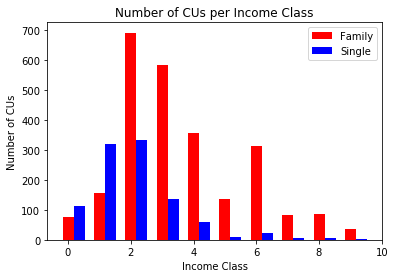

[690 583 355 311 156 136  86  83  76  36]
[331 319 136 114  58  21   9   7   6   3]


In [19]:
plt.close()
n_groups = 3
values1 = cleanFamily.INCLASS.value_counts().values
values2 = cleanSingle.INCLASS.value_counts().values

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1

 
rects1 = plt.bar(cleanFamily.INCLASS.value_counts().index -1, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')

rects2 = plt.bar(cleanSingle.INCLASS.value_counts().index - 1 + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

plt.xlabel('Income Class')
plt.ylabel('Number of CUs')
plt.title('Number of CUs per Income Class')
plt.legend()
plt.show()
print(cleanFamily.INCLASS.value_counts().values)
print(cleanSingle.INCLASS.value_counts().values)

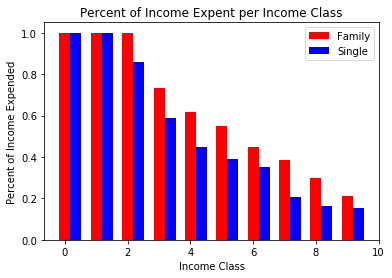

In [20]:
n_groups = 3
values1 = cleanPercentagesFamily.ExpInc
values2 = cleanPercentagesSingle.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

### Looking at the Family vs Single Healthcare costs
Note: The higher income brackets are not statistically significant for the Single people because there are so few observations (<50)

0.13504256404815956
0.1178643559905537


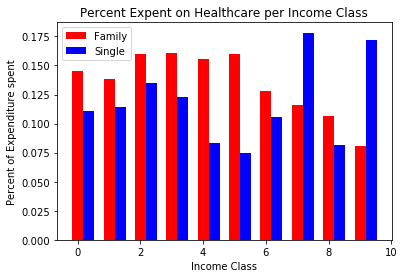

In [21]:
print(cleanPercentagesFamily.iHealthcare.mean())
print(cleanPercentagesSingle.iHealthcare.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iHealthcare
values2 = cleanPercentagesSingle.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Healthcare per Income Class')
plt.legend()
plt.show()

### Looking at the Family vs Single Transportation costs
Note: The higher income brackets are not statistically significant for the Single people because there are so few observations (<50)

0.12496255439659536
0.10724402219295588


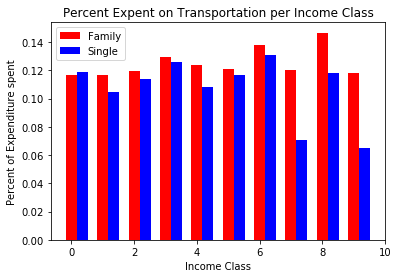

In [22]:
print(cleanPercentagesFamily.iTransportation.mean())
print(cleanPercentagesSingle.iTransportation.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iTransportation
values2 = cleanPercentagesSingle.iTransportation

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Transportation per Income Class')
plt.legend()
plt.show()

### Looking at Single vs Family housing costs

0.3443828338102582
0.4124653416522002


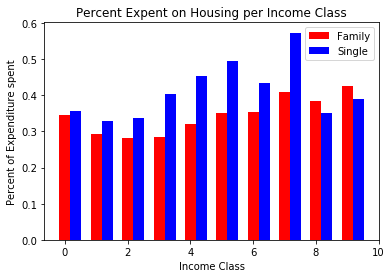

In [23]:
print(cleanPercentagesFamily.iHousing.mean())
print(cleanPercentagesSingle.iHousing.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iHousing
values2 = cleanPercentagesSingle.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Housing per Income Class')
plt.legend()
plt.show()

0.13504256404815956
0.1178643559905537


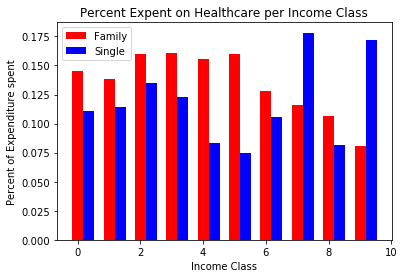

In [24]:
print(cleanPercentagesFamily.iHealthcare.mean())
print(cleanPercentagesSingle.iHealthcare.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iHealthcare
values2 = cleanPercentagesSingle.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Healthcare per Income Class')
plt.legend()
plt.show()

0.003505038489813575
0.0


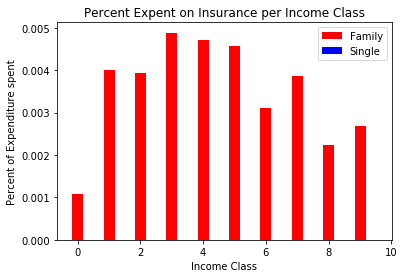

In [25]:
print(cleanPercentagesFamily.iInsurance.mean())
print(cleanPercentagesSingle.iInsurance.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iInsurance
values2 = cleanPercentagesSingle.iInsurance

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Insurance per Income Class')
plt.legend()
plt.show()

In [26]:
valueFam = cleanFamily.iTotalExp
valueSingle = cleanSingle.iTotalExp

incomeFam = cleanFamily.FINCBTXM
incomeSingle = cleanSingle.FINCBTXM

x = list(range(0,int(incomeFam.max()),1000))

famCoefficients = np.polyfit(incomeFam, valueFam, deg = 3)
singleCoefficients = np.polyfit(incomeSingle, valueSingle, deg = 3)

famP = np.poly1d(famCoefficients)
singleP = np.poly1d(singleCoefficients)

breakEvenLine = list(range(0,294000,1000))

trace0 = go.Scatter(x = incomeFam,
                    y = valueFam, 
                    mode = 'markers',
                    name = "Family Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(255, 125, 5, 1)'))
trace1 = go.Scatter(x = x, 
                    y = famP(x),
                    name = "Family Regression",
                    mode = "lines", 
                   line = dict(color = 'rgba(255,5,9,1)'))

trace2 = go.Scatter(x = incomeSingle,
                    y = valueSingle, 
                    mode = 'markers',
                    name = "Single Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(5, 255, 250, 1)'))
trace3 = go.Scatter(x = x, 
                    y = singleP(x),
                    name = "Single Regression",
                    mode = "lines",
                    line = dict(
                       color = 'rgba(5, 9, 255,1)'))


trace4 = go.Scatter(x=breakEvenLine,
                   y=breakEvenLine,
                   mode = "lines",
                    name = "Income = Expenditure",
                   line = dict(color = 'rgba(0,0,0,1)'))

layout = dict(title = 'Family Vs Single Aggregate Expenses',
              xaxis = dict(title = 'Income Before Taxes'),
              yaxis = dict(title = 'Aggregate Expenses'),
              )

data = [trace0,trace1, trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename="Family Vs Single Aggregate Expenses")

In [27]:
valueFam = cleanFamily.iHousing
valueSingle = cleanSingle.iHousing

incomeFam = cleanFamily.FINCBTXM
incomeSingle = cleanSingle.FINCBTXM

famCoefficients = np.polyfit(incomeFam, valueFam, deg = 3)
singleCoefficients = np.polyfit(incomeSingle, valueSingle, deg = 3)

famP = np.poly1d(famCoefficients)
singleP = np.poly1d(singleCoefficients)

trace0 = go.Scatter(x = incomeFam,
                    y = valueFam, 
                    mode = 'markers',
                    name = "Family Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(255, 125, 5, 1)'))
trace1 = go.Scatter(x = x, 
                    y = famP(x),
                    name = "Family Regression",
                    mode = "lines", 
                   line = dict(color = 'rgba(255,5,9,1)'))

trace2 = go.Scatter(x = incomeSingle,
                    y = valueSingle, 
                    mode = 'markers',
                    name = "Single Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(5, 255, 250, 1)'))
trace3 = go.Scatter(x = x, 
                    y = singleP(x),
                    name = "Single Regression",
                    mode = "lines", 
                   line = dict(color = 'rgba(5, 9, 255,1)'))

layout = dict(title = 'Family Vs Single Housing Expenses',
              xaxis = dict(title = 'Income Before Taxes'),
              yaxis = dict(title = 'Amount Spent on Housing'),
              )

data = [trace0,trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename="Family Vs Single Housing")

In [28]:
valueFam = cleanFamily.iTransportation
valueSingle = cleanSingle.iTransportation

incomeFam = cleanFamily.FINCBTXM
incomeSingle = cleanSingle.FINCBTXM

famCoefficients = np.polyfit(incomeFam, valueFam, deg = 3)
singleCoefficients = np.polyfit(incomeSingle, valueSingle, deg = 3)

famP = np.poly1d(famCoefficients)
singleP = np.poly1d(singleCoefficients)

trace0 = go.Scatter(x = incomeFam,
                    y = valueFam, 
                    mode = 'markers',
                    name = "Family Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(255, 125, 5, 1)'))
trace1 = go.Scatter(x = x, 
                    y = famP(x),
                    name = "Family Regression",
                    mode = "lines", 
                   line = dict(color = 'rgba(255,5,9,1)'))

trace2 = go.Scatter(x = incomeSingle,
                    y = valueSingle, 
                    mode = 'markers',
                    name = "Single Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(5, 255, 250, 1)'))
trace3 = go.Scatter(x = x, 
                    y = singleP(x),
                    name = "Single Regression",
                    mode = "lines", 
                   line = dict(color = 'rgba(5, 9, 255,1)'))

layout = dict(title = 'Family Vs Single Transportation Expenses',
              xaxis = dict(title = 'Income Before Taxes'),
              yaxis = dict(title = 'Amount Spent on Transportation'),
              )

data = [trace0,trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename="Family Vs Single Transportation")

In [29]:
valueFam = cleanFamily.iHealthcare
valueSingle = cleanSingle.iHealthcare

incomeFam = cleanFamily.FINCBTXM
incomeSingle = cleanSingle.FINCBTXM

famCoefficients = np.polyfit(incomeFam, valueFam, deg = 3)
singleCoefficients = np.polyfit(incomeSingle, valueSingle, deg = 3)

famP = np.poly1d(famCoefficients)
singleP = np.poly1d(singleCoefficients)

trace0 = go.Scatter(x = incomeFam,
                    y = valueFam, 
                    mode = 'markers',
                    name = "Family Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(255, 125, 5, 1)'))
trace1 = go.Scatter(x = x, 
                    y = famP(x),
                    name = "Family Regression",
                    mode = "lines", 
                   line = dict(color = 'rgba(255,5,9,1)'))

trace2 = go.Scatter(x = incomeSingle,
                    y = valueSingle, 
                    mode = 'markers',
                    name = "Single Points",
                    marker = dict(
                        size = 3,
                        color = 'rgba(5, 255, 250, 1)'))
trace3 = go.Scatter(x = x, 
                    y = singleP(x),
                    name = "Single Regression",
                    mode = "lines", 
                   line = dict(color = 'rgba(5, 9, 255,1)'))

layout = dict(title = 'Family Vs Single Healthcare Expenses',
              xaxis = dict(title = 'Income Before Taxes'),
              yaxis = dict(title = 'Amount Spent on Healthcare'),
              )

data = [trace0,trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename="Family Vs Single Healthcare")

In [30]:
# cleanPercentagesFamily

In [31]:
# cleanPercentagesSingle

In [32]:
single = pd.read_csv("singlePercentages.csv")
# derived income brackets from incomeBrackets.py
singleIncomeBrackets = [-10000000, 15000, 20000, 25000, 30000, 40000, 50000, 65000, 9995000]
family = pd.read_csv("familyPercentages.csv")
# derived income brackets from incomeBrackets.py
familyIncomeBrackets = [-10000000, 5000, 15000, 20000, 25000, 30000, 120000, 145000, 190000, 9995000]

In [33]:
single = single.iloc[:,1:]
printIncomeBrackets(singleIncomeBrackets)
single

0
-10000000 - 15000
1
15000 - 20000
2
20000 - 25000
3
25000 - 30000
4
30000 - 40000
5
40000 - 50000
6
50000 - 65000
7
65000 - 9995000


,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.154806,0.068744,0.359988,0.125191,0.024710,0.108057,0.106185,0.047194,0.009706,0.021999,0.0,0.0,0.026581,1.000000
1,0.149916,0.080662,0.297104,0.138663,0.024999,0.109028,0.124860,0.056914,0.010851,0.028861,0.0,0.0,0.021857,1.000000
2,0.154489,0.066730,0.314581,0.124564,0.023353,0.108473,0.140809,0.059431,0.010897,0.027683,0.0,0.0,0.031011,1.000000
3,0.136541,0.068785,0.376067,0.108924,0.022584,0.117432,0.114049,0.052153,0.007458,0.027586,0.0,0.0,0.031578,0.848754
4,0.138386,0.067219,0.334665,0.111809,0.020911,0.116317,0.145369,0.052487,0.008168,0.030293,0.0,0.0,0.025623,0.734923
5,0.127855,0.062833,0.397183,0.106285,0.028183,0.123492,0.124712,0.055671,0.006346,0.027498,0.0,0.0,0.060058,0.638548
6,0.116736,0.068639,0.430999,0.101953,0.024077,0.114865,0.111109,0.065645,0.005574,0.024942,0.0,0.0,0.064539,0.513638
7,0.109048,0.080631,0.446726,0.097900,0.031486,0.117714,0.098735,0.059673,0.005638,0.020833,0.0,0.0,0.068384,0.319477


In [34]:
family = family.iloc[:,1:]
printIncomeBrackets(familyIncomeBrackets)
family

0
-10000000 - 5000
1
5000 - 15000
2
15000 - 20000
3
20000 - 25000
4
25000 - 30000
5
30000 - 120000
6
120000 - 145000
7
145000 - 190000
8
190000 - 9995000


,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.159942,0.051543,0.327599,0.132920,0.025368,0.110529,0.170453,0.045418,0.018115,0.016215,0.000865,0.0,0.058967,1.000000
1,0.171670,0.063705,0.303374,0.124310,0.023738,0.114066,0.146223,0.049683,0.008895,0.034725,0.003382,0.0,0.043772,1.000000
2,0.159213,0.071673,0.314603,0.117620,0.023359,0.121753,0.123880,0.058896,0.005825,0.031968,0.003219,0.0,0.032009,1.000000
3,0.165820,0.070782,0.286269,0.121914,0.029130,0.116410,0.155939,0.054648,0.012037,0.023522,0.001575,0.0,0.038047,1.000000
4,0.167335,0.074919,0.228555,0.133259,0.023162,0.120533,0.167895,0.049232,0.010730,0.037903,0.005918,0.0,0.019442,1.000000
5,0.142506,0.069042,0.313551,0.112869,0.027274,0.126907,0.152878,0.051044,0.011388,0.033900,0.004310,0.0,0.045669,0.644795
6,0.125733,0.070630,0.385072,0.113420,0.034077,0.126511,0.128947,0.049568,0.006970,0.026475,0.003299,0.0,0.070703,0.386639
7,0.126490,0.067391,0.419318,0.098527,0.030929,0.135727,0.101022,0.047351,0.006980,0.029021,0.003267,0.0,0.066022,0.352250
8,0.128142,0.086176,0.390393,0.098898,0.038624,0.138885,0.092663,0.046041,0.008275,0.024132,0.002126,0.0,0.054356,0.236750


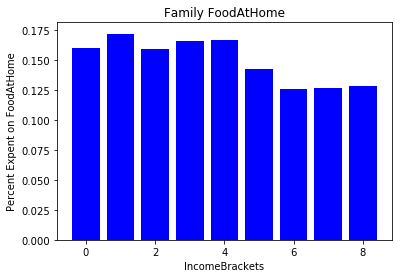

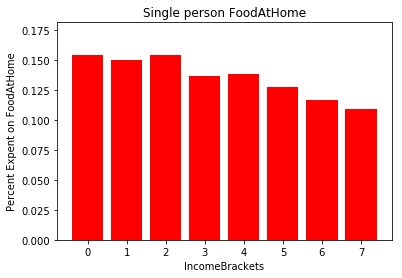

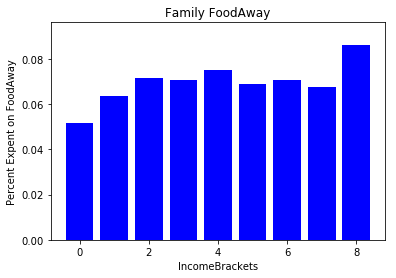

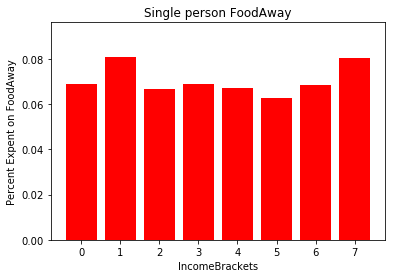

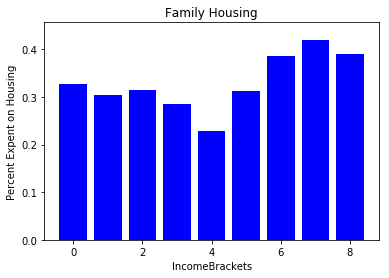

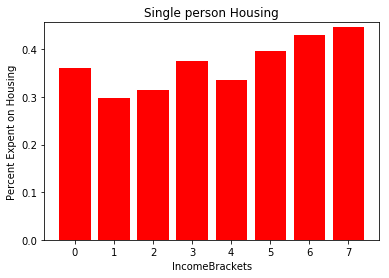

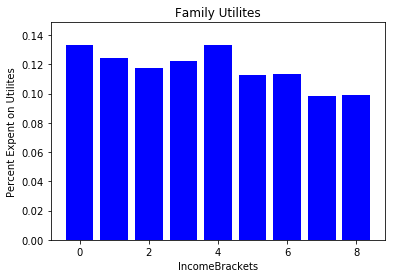

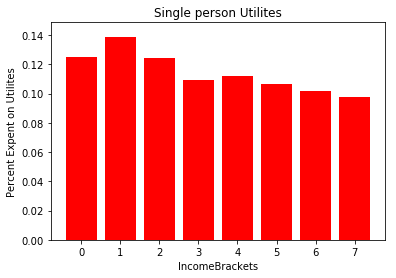

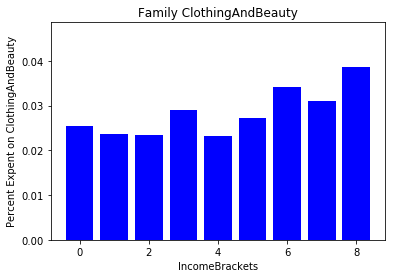

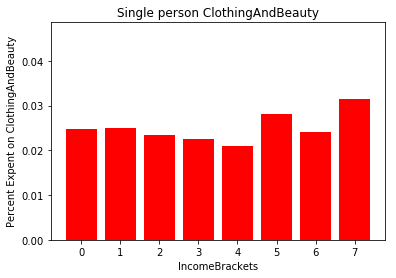

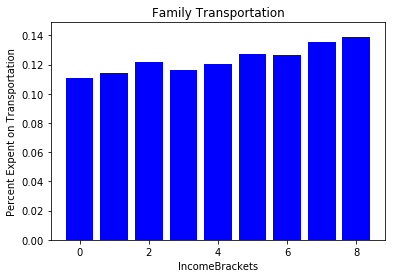

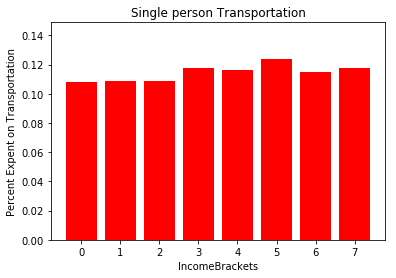

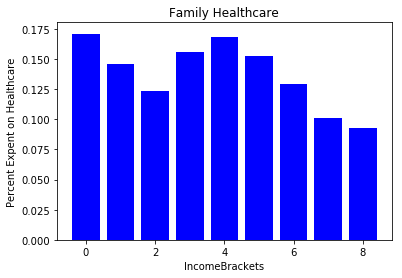

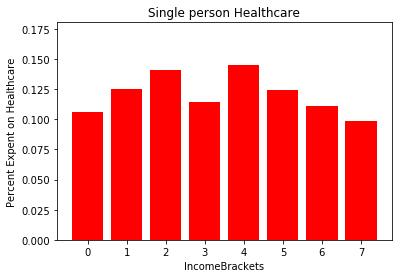

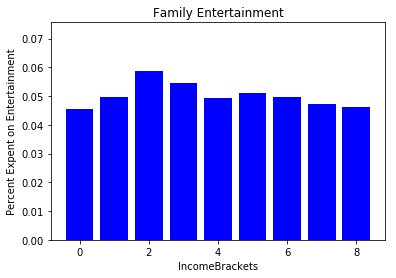

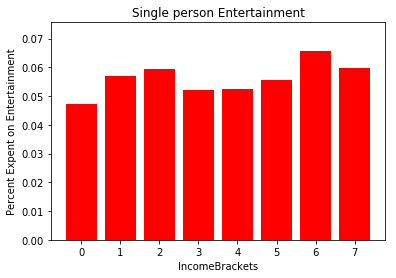

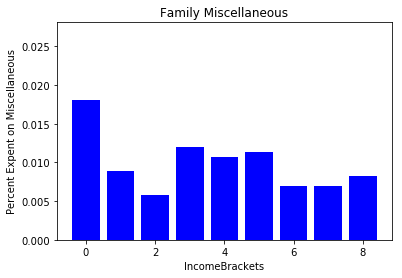

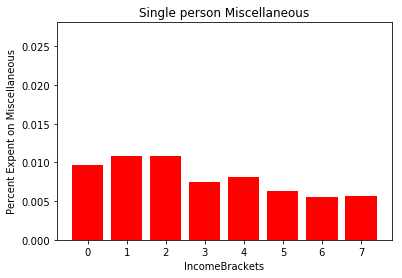

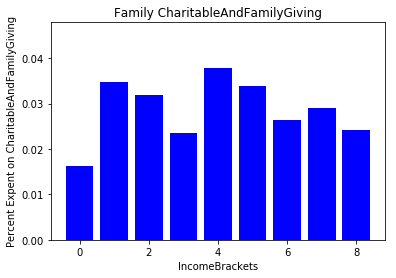

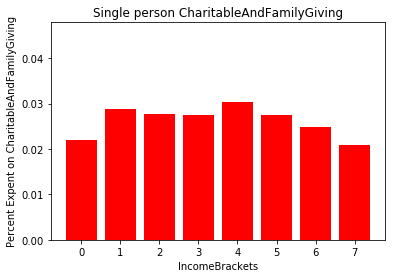

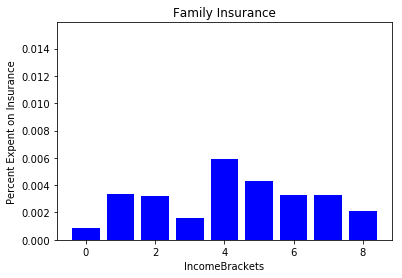

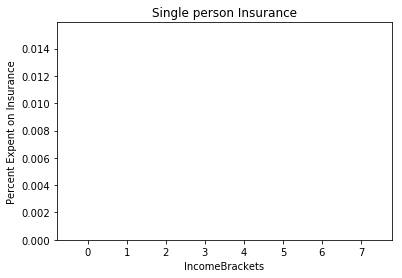

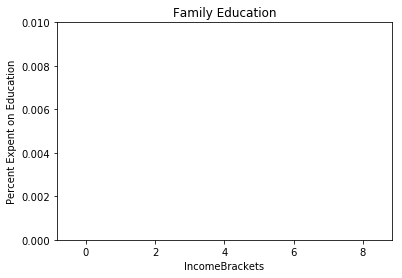

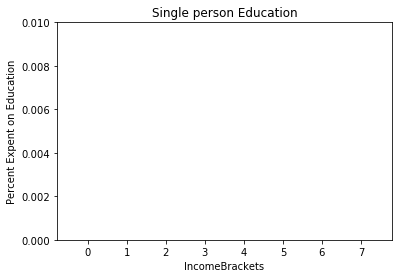

In [35]:
plt.close()
for x in range(len(family.columns)-2):
    familyMax = family.iloc[:,x].max()
    singleMax = single.iloc[:,x].max()
    ylimit = max([familyMax, singleMax]) + 0.01
    # family
    familyCol = list(family.iloc[:,x])
    colName = family.columns[x]
    colName = colName[1:]
    plt.bar(family.index,familyCol,color='b')
    plt.title("Family "+colName)
    plt.xlabel("IncomeBrackets")
    plt.ylabel("Percent Expent on "+colName)
    plt.ylim(0,ylimit)
    plt.show()
    
    # single
    singleCol = list(single.iloc[:,x])
    colName = single.columns[x]
    colName = colName[1:]
    plt.bar(single.index,singleCol,color='r')
    plt.title("Single person "+colName)
    plt.xlabel("IncomeBrackets")
    plt.ylabel("Percent Expent on "+colName)
    plt.ylim(0,ylimit)
    plt.show()
    